In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pprint
import numpy as np
import pandas as pd
# from pathlib import Path

from matplotlib import pyplot as plt
# import seaborn as sns
# import scanpy as sc

# from sklearn.metrics import adjusted_rand_score
# from IPython.display import display, HTML

import warnings
from numba.core.errors import NumbaDeprecationWarning

# from calicost import arg_parse

In [75]:
from sim_analysis import (
    get_config,
    get_sampleid,
    get_best_r_hmrf,
    get_rdrbaf,
    get_gene_loc_path,
    get_true_clones_path,
    get_true_clones,
    get_truth_cna_file,
    get_sim_runs,
    get_numbat_path,
    get_numbat_clones,
    get_starch_clones,
    plot_clones,
    get_calico_clones,
    get_cna_seglevel,
    read_gene_loc,
    read_true_gene_cna,
    read_calico_gene_cna,
    read_numbat_gene_cna,
    read_starch_gene_cna,
    compute_gene_F1,
    get_clone_aris, 
    plot_aris,
    get_f1s,
    plot_f1s,
    plot_rdr_baf
)

## Configuration

In [4]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [5]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 20)

plt.rcParams.update({'font.size': 14})
# sc.set_figure_params(dpi=120)

In [6]:
true_dir = "../simulated_data_related"
calico_pure_dir = "../nomixing_calicost_related"
numbat_dir = "../numbat_related"
starch_dir = "../starch_related"

calico_repo_dir = "/Users/mw9568/Work/ragr/CalicoST/"

# hg_table_file = "/nfs/turbo/umms-congma1/projects/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"
hg_table_file = get_gene_loc_path(calico_repo_dir)

## Preface

Note:
 - min. 100 spots per clone
 - assumes (max.) of 3 clones

### Available Runs

In [7]:
sim_runs = get_sim_runs()
sim_runs

n_cnas cna_size  ploidy  random                               sampleid
0   (1, 2)      1e7       2       0  numcnas1.2_cnasize1e7_ploidy2_random0
1   (1, 2)      1e7       2       1  numcnas1.2_cnasize1e7_ploidy2_random1
2   (1, 2)      1e7       2       2  numcnas1.2_cnasize1e7_ploidy2_random2
3   (1, 2)      1e7       2       3  numcnas1.2_cnasize1e7_ploidy2_random3
4   (1, 2)      1e7       2       4  numcnas1.2_cnasize1e7_ploidy2_random4
..     ...      ...     ...     ...                                    ...
85  (6, 3)      5e7       2       5  numcnas6.3_cnasize5e7_ploidy2_random5
86  (6, 3)      5e7       2       6  numcnas6.3_cnasize5e7_ploidy2_random6
87  (6, 3)      5e7       2       7  numcnas6.3_cnasize5e7_ploidy2_random7
88  (6, 3)      5e7       2       8  numcnas6.3_cnasize5e7_ploidy2_random8
89  (6, 3)      5e7       2       9  numcnas6.3_cnasize5e7_ploidy2_random9

[90 rows x 5 columns]

### Config for a given run

In [86]:
sim_id = 2

# NB [(1, 2), "1e7", 2, random], [(3, 3), "3e7", 2, random]
run = sim_runs[["n_cnas", "cna_size", "ploidy", "random"]].iloc[sim_id].values

config = get_config(calico_pure_dir, *run, verbose=True)

Reading configuration file: ../nomixing_calicost_related/numcnas1.2_cnasize1e7_ploidy2_random2/configfile0
  snp_dir: /u/congma/ragr-data/users/congma/Datasets/CalicoST_simulation/simulated_data_related/numcnas1.2_cnasize1e7_ploidy2_random2
  output_dir: /u/congma/ragr-data/users/congma/Datasets/CalicoST_simulation/nomixing_calicost_related/numcnas1.2_cnasize1e7_ploidy2_random2
  geneticmap_file: /u/congma/ragr-data/users/congma/Codes/CalicoST/resources/genetic_map_GRCh38_merged.tab
  hgtable_file: /u/congma/ragr-data/users/congma/Codes/STARCH_crazydev/hgTables_hg38_gencode.txt
  normalidx_file: None
  tumorprop_file: None
  supervision_clone_file: None
  filtergenelist_file: /n/fs/ragr-data/users/congma/references/cellranger_refdata-gex-GRCh38-2020-A/genes/ig_gene_list.txt
  filterregion_file: /n/fs/ragr-data/users/congma/references/cellranger_refdata-gex-GRCh38-2020-A/genes/HLA_regions.bed
  secondary_min_umi: 200
  min_snpumi_perspot: 50
  min_percent_expressed_spots: 0.005
  bafonl

In [90]:
true_clones = get_true_clones(true_dir, *run)
calico_clones = get_calico_clones(calico_pure_dir, *run, true_dir=true_dir)
starch_clones = get_starch_clones(starch_dir, *run, true_clones=true_clones)
numbat_clones = get_numbat_clones(numbat_dir, *run, true_clones=true_clones)
calico_clones

est_clone true_clone   x   y
spot                              
0             1          0   0   0
1             1          0   0   2
2             1          0   0   4
3             1          0   0   6
4             1          0   0   8
...         ...        ...  ..  ..
2995          1          1  99  51
2996          1          1  99  53
2997          1          1  99  55
2998          1          1  99  57
2999          1          1  99  59

[3000 rows x 4 columns]

/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:932: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:932: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:932: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:932: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  


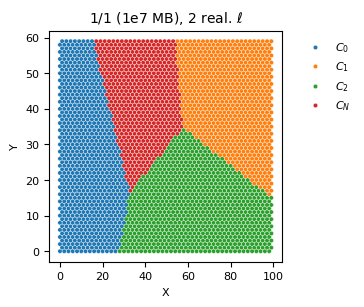

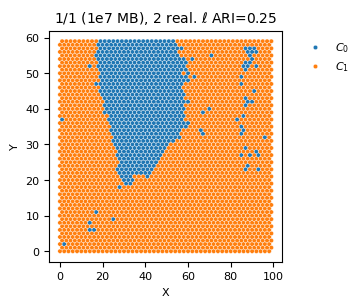

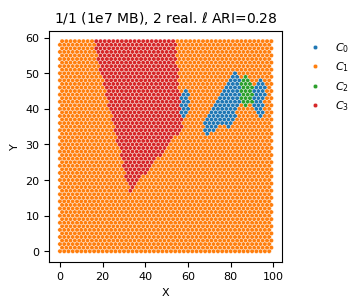

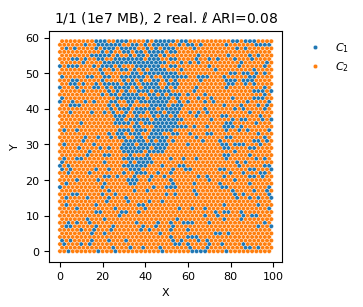

In [91]:
_ = plot_clones(true_clones, *run, truth=True)
_ = plot_clones(calico_clones, *run)
_ = plot_clones(starch_clones, *run)
_ = plot_clones(numbat_clones, *run)

In [92]:
cna_seglevel = get_cna_seglevel(
    calico_pure_dir,
    get_sampleid(*run),
    get_best_r_hmrf(calico_pure_dir, *run),
    ploidy="diploid",
    non_neutral_only=True,
)

print(cna_seglevel)

    chr      start        end  clone0 a  clone0 b  clone1 a  clone1 b  global_cna
0     2    9951693   10002175         1         1         3         3       False
1     3   33798571   34673053         3         3         1         1       False
2    13  105465867  108230401         1         1         1         3       False
3    13  108251240  110512919         1         1         1         3       False
4    13  110523066  110549881         1         1         1         3       False
5    13  110641412  110695934         1         1         1         3       False
6    13  110878540  110899056         1         1         1         3       False
7    13  111114559  112522023         1         1         1         3       False
8    13  112690329  112878800         1         1         1         3       False
9    13  112967484  113235709         1         1         1         3       False
10   13  113297239  113856450         1         1         1         3       False
11   13  1139777

In [93]:
true_gene_cna = read_true_gene_cna(
    read_gene_loc(hg_table_file),
    get_truth_cna_file(true_dir, get_sampleid(*run)),
    non_neutral_only=True
)
true_gene_cna

chr      start        end  clone0 a  clone0 b clone0_gtype clone0_ctype  clone1 a  clone1 b clone1_gtype clone1_ctype  clone2 a  clone2 b clone2_gtype clone2_ctype  global_cna
0      2  195003711  195026370         1         2          1|2          AMP         1         1          1|1          NEU         1         1          1|1          NEU       False
1      2  195448532  195481827         1         2          1|2          AMP         1         1          1|1          NEU         1         1          1|1          NEU       False
2      2  195451778  195515699         1         2          1|2          AMP         1         1          1|1          NEU         1         1          1|1          NEU       False
3      2  195532945  195540287         1         2          1|2          AMP         1         1          1|1          NEU         1         1          1|1          NEU       False
4      2  195569628  195572970         1         2          1|2          AMP         1         1          1|1          NEU         1         1          1|1          NEU       False
..   ...        ...        ...       ...       ...          ...          ...       ...       ...          ...          ...       ...       ...          ...          ...         ...
919   17   52390515   52535701         1         0          1|0          DEL         1         0          1|0          DEL         1         0          1|0          DEL       False
920   17   52862121   52899588         1         0          1|0          DEL         1         0          1|0          DEL         1         0          1|0          DEL       False
921   17   52985513   52987652         1         0          1|0          DEL         1         0          1|0          DEL         1         0          1|0          DEL       False
922   17   53276760   54365634         1         0          1|0          DEL         1         0          1|0          DEL         1         0          1|0          DEL       False
923   17   53822927   53825193         1         0          1|0          DEL         1         0          1|0          DEL         1         0          1|0          DEL       False

[924 rows x 16 columns]

/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:347: RuntimeWarning: invalid value encountered in divide
  y=X[:, 0, c] / base_nb_mean[:, c],
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:347: RuntimeWarning: invalid value encountered in divide
  y=X[:, 0, c] / base_nb_mean[:, c],


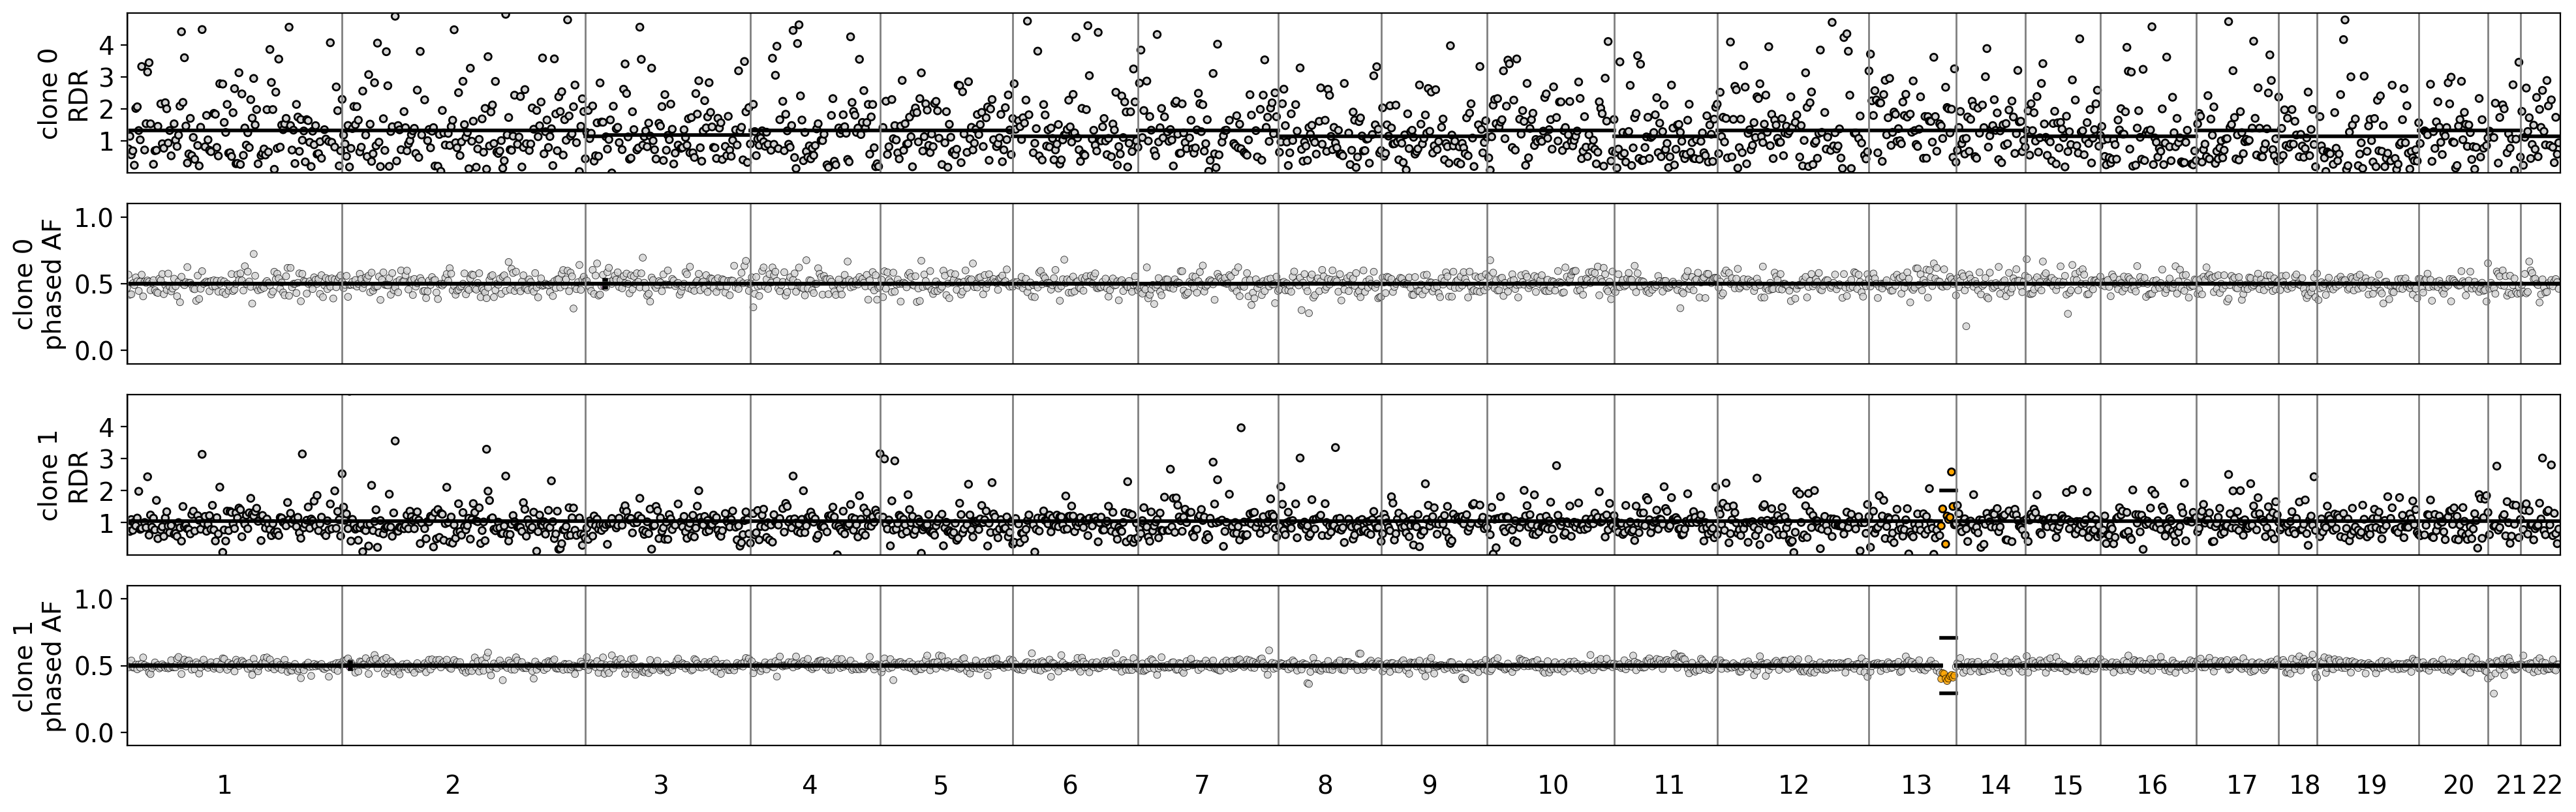

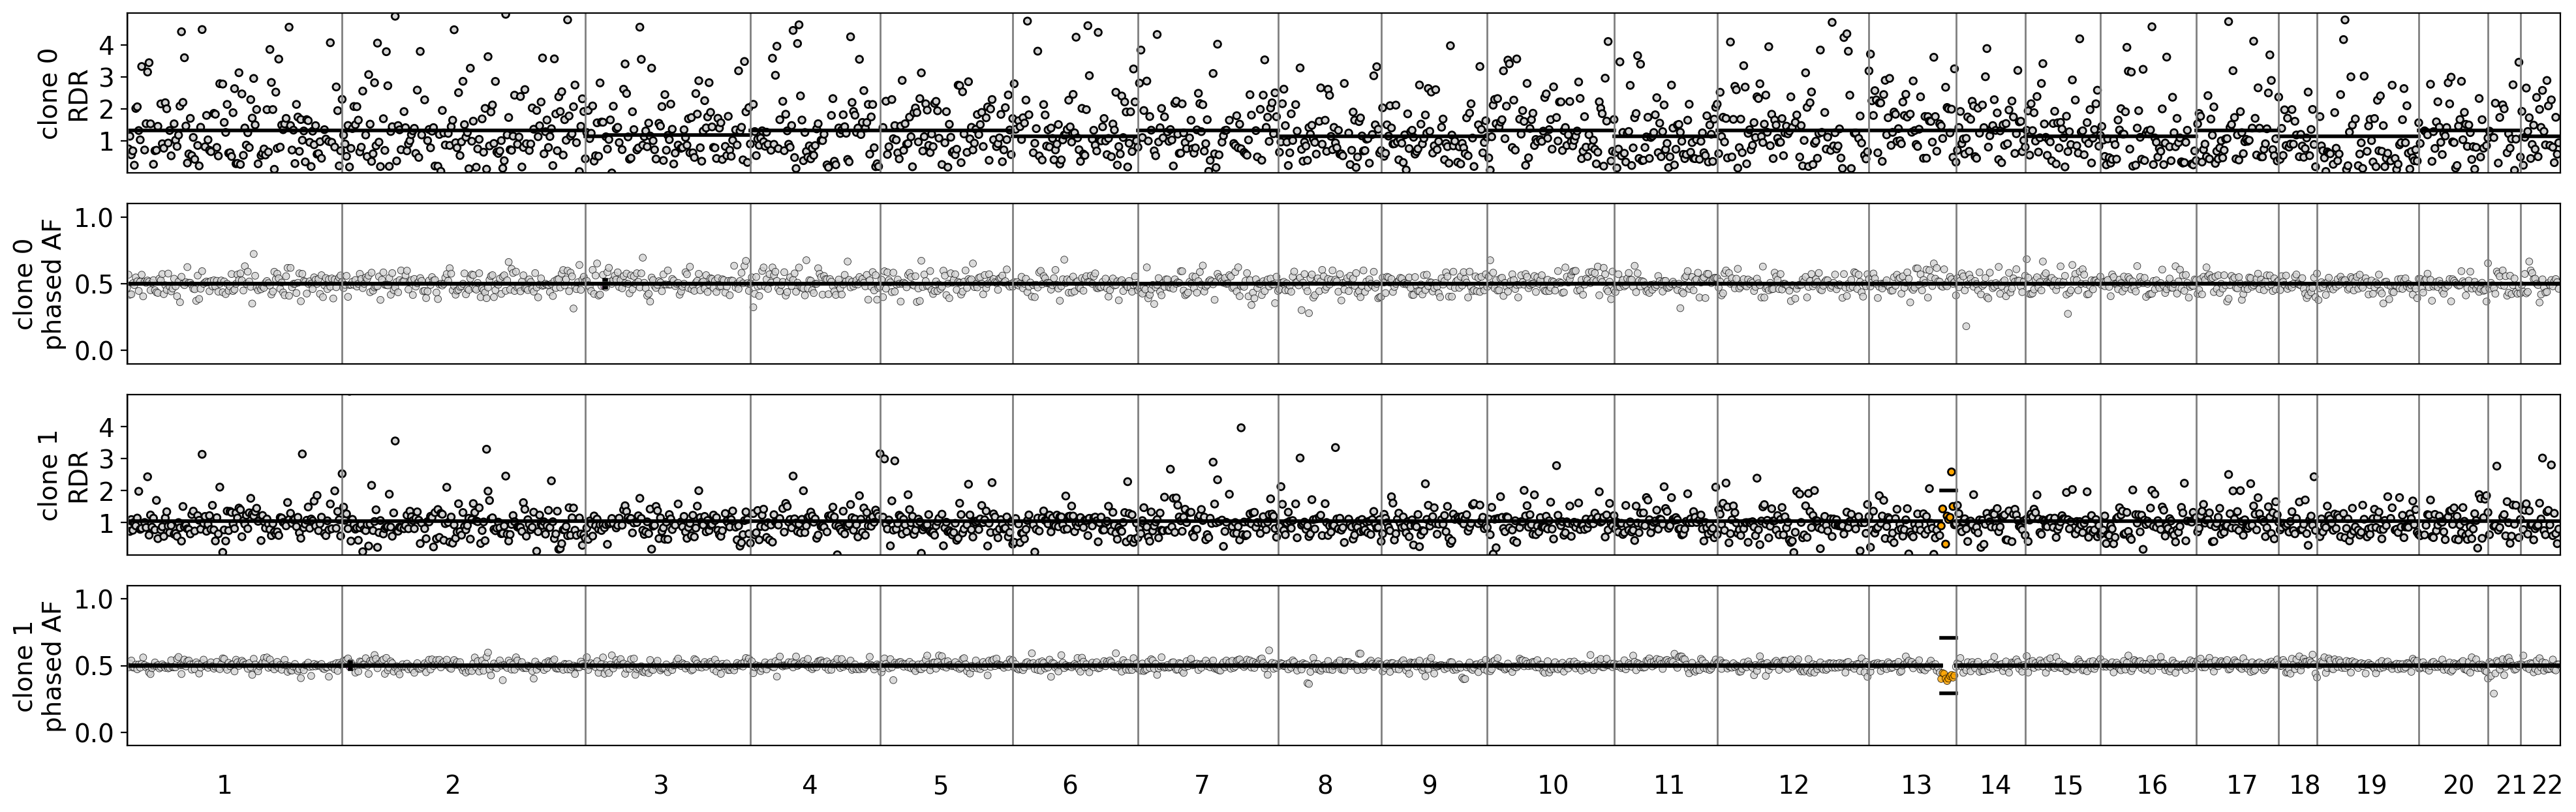

In [94]:
plot_rdr_baf(calico_pure_dir, *run)

# Clone identification accuracy

In [98]:
clone_aris = get_clone_aris(true_dir, calico_pure_dir, numbat_dir, starch_dir)
clone_aris

/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1046: UserWarning: 
../numbat_related/numcnas1.2_cnasize1e7_ploidy2_random0/outs/clone_post_2.tsv does not exist.
  
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1046: UserWarning: 
../numbat_related/numcnas1.2_cnasize1e7_ploidy2_random1/outs/clone_post_2.tsv does not exist.
  
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1046: UserWarning: 
../numbat_related/numcnas1.2_cnasize1e7_ploidy2_random4/outs/clone_post_2.tsv does not exist.
  
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:130: UserWarning: CalicoST RDR/BAF determinations do not exist for ../nomixing_calicost_related/numcnas1.2_cnasize1e7_ploidy2_random5/clone3_rectangle5_w1.0/rdrbaf_final_nstates7_smp.npz
  warnings.warning(
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:179: UserWarning: ../nomixing_calicost_related/numcnas1.2_cnasize1e7_ploidy2_random5/clone3_rectangle5_w1.0/rdrbaf_final_nstates7_smp.npz does not exist.
  d

ValueError: No objects to concatenate

/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1187: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.boxplot(
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1199: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.stripplot(
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1187: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.boxplot(
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1199: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.stripplot(
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1187: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.boxplot(
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:1199: UserWarning: The palette list has more values (20) than needed (3), 

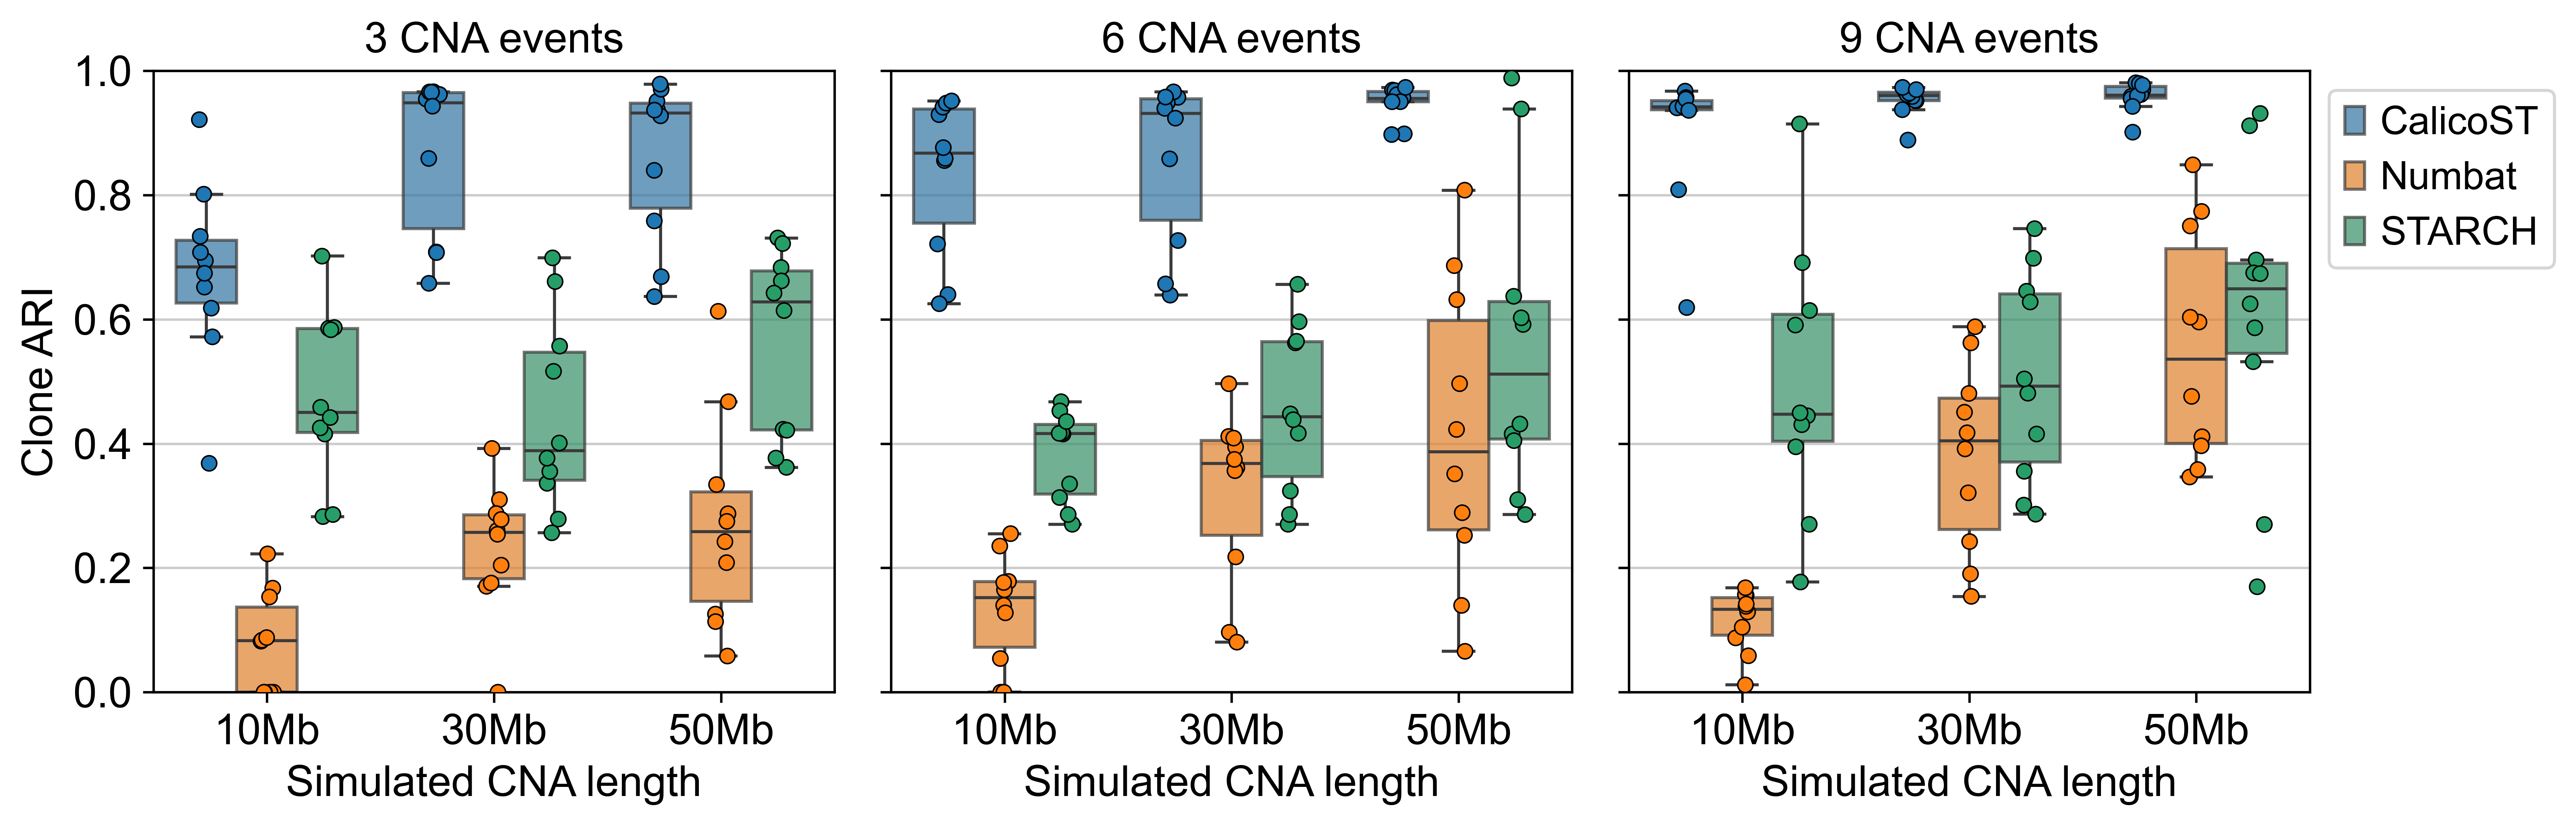

In [33]:
plot_aris(clone_aris)

# Event detection accuracy

The detection accuracy is evalated on a per-gene level:
the precision & sensitivity of genes involved in each category of event (Deletion, Amplication, LOH) for all events.

In [34]:
# NB (chr, start, end) for a given gene list.
df_hgtable = read_gene_loc(hg_table_file)
df_hgtable

chr     start       end
gene                               
FAM138A       1     34554     36081
OR4F5         1     65419     71585
AL627309.1    1     89295    133723
AL627309.3    1     89551     91105
AL627309.2    1    139790    140339
...         ...       ...       ...
SHANK3       22  50674415  50733298
AC000036.1   22  50735825  50738139
ACR          22  50738196  50745339
AC002056.2   22  50740593  50743520
RABL2B       22  50767501  50783663

[35299 rows x 3 columns]

In [35]:
df_event_f1 = get_f1s(true_dir, df_hgtable, calico_pure_dir, numbat_dir, starch_dir)
df_event_f1

cnas  n_cnas cna_size  ploidy  random                              sample_id                                   true_clones_path    method    event        F1                                           true_cna                                       est_cna_file
0     (1, 2)       3     10Mb       2       0  numcnas1.2_cnasize1e7_ploidy2_random0  ../simulated_data_related/numcnas1.2_cnasize1e...  CalicoST      DEL  0.378378  ../simulated_data_related/numcnas1.2_cnasize1e...  ../nomixing_calicost_related/numcnas1.2_cnasiz...
1     (1, 2)       3     10Mb       2       0  numcnas1.2_cnasize1e7_ploidy2_random0  ../simulated_data_related/numcnas1.2_cnasize1e...  CalicoST      AMP  0.115756  ../simulated_data_related/numcnas1.2_cnasize1e...  ../nomixing_calicost_related/numcnas1.2_cnasiz...
2     (1, 2)       3     10Mb       2       0  numcnas1.2_cnasize1e7_ploidy2_random0  ../simulated_data_related/numcnas1.2_cnasize1e...  CalicoST    CNLOH  0.790698  ../simulated_data_related/numcnas1.2_cnasize1e...  ../nomixing_calicost_related/numcnas1.2_cnasiz...
3     (1, 2)       3     10Mb       2       0  numcnas1.2_cnasize1e7_ploidy2_random0  ../simulated_data_related/numcnas1.2_cnasize1e...  CalicoST  overall       NaN  ../simulated_data_related/numcnas1.2_cnasize1e...  ../nomixing_calicost_related/numcnas1.2_cnasiz...
4     (1, 2)       3     10Mb       2       0  numcnas1.2_cnasize1e7_ploidy2_random0  ../simulated_data_related/numcnas1.2_cnasize1e...    Numbat      DEL       0.0  ../simulated_data_related/numcnas1.2_cnasize1e...                                                  -
...      ...     ...      ...     ...     ...                                    ...                                                ...       ...      ...       ...                                                ...                                                ...
1075  (6, 3)       9     50Mb       2       9  numcnas6.3_cnasize5e7_ploidy2_random9  ../simulated_data_related/numcnas6.3_cnasize5e...    Numbat  overall       NaN  ../simulated_data_related/numcnas6.3_cnasize5e...  ../numbat_related/numcnas6.3_cnasize5e7_ploidy...
1076  (6, 3)       9     50Mb       2       9  numcnas6.3_cnasize5e7_ploidy2_random9  ../simulated_data_related/numcnas6.3_cnasize5e...    Starch      DEL  0.134228  ../simulated_data_related/numcnas6.3_cnasize5e...  ../starch_related/numcnas6.3_cnasize5e7_ploidy...
1077  (6, 3)       9     50Mb       2       9  numcnas6.3_cnasize5e7_ploidy2_random9  ../simulated_data_related/numcnas6.3_cnasize5e...    Starch      AMP       0.0  ../simulated_data_related/numcnas6.3_cnasize5e...  ../starch_related/numcnas6.3_cnasize5e7_ploidy...
1078  (6, 3)       9     50Mb       2       9  numcnas6.3_cnasize5e7_ploidy2_random9  ../simulated_data_related/numcnas6.3_cnasize5e...    Starch    CNLOH       0.0  ../simulated_data_related/numcnas6.3_cnasize5e...  ../starch_related/numcnas6.3_cnasize5e7_ploidy...
1079  (6, 3)       9     50Mb       2       9  numcnas6.3_cnasize5e7_ploidy2_random9  ../simulated_data_related/numcnas6.3_cnasize5e...    Starch  overall       NaN  ../simulated_data_related/numcnas6.3_cnasize5e...  ../starch_related/numcnas6.3_cnasize5e7_ploidy...

[1080 rows x 12 columns]

[autoreload of sim_analysis failed: Traceback (most recent call last):
  File "/Users/mw9568/miniforge3/envs/calicost_sim/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mw9568/miniforge3/envs/calicost_sim/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/mw9568/miniforge3/envs/calicost_sim/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py", line 1220

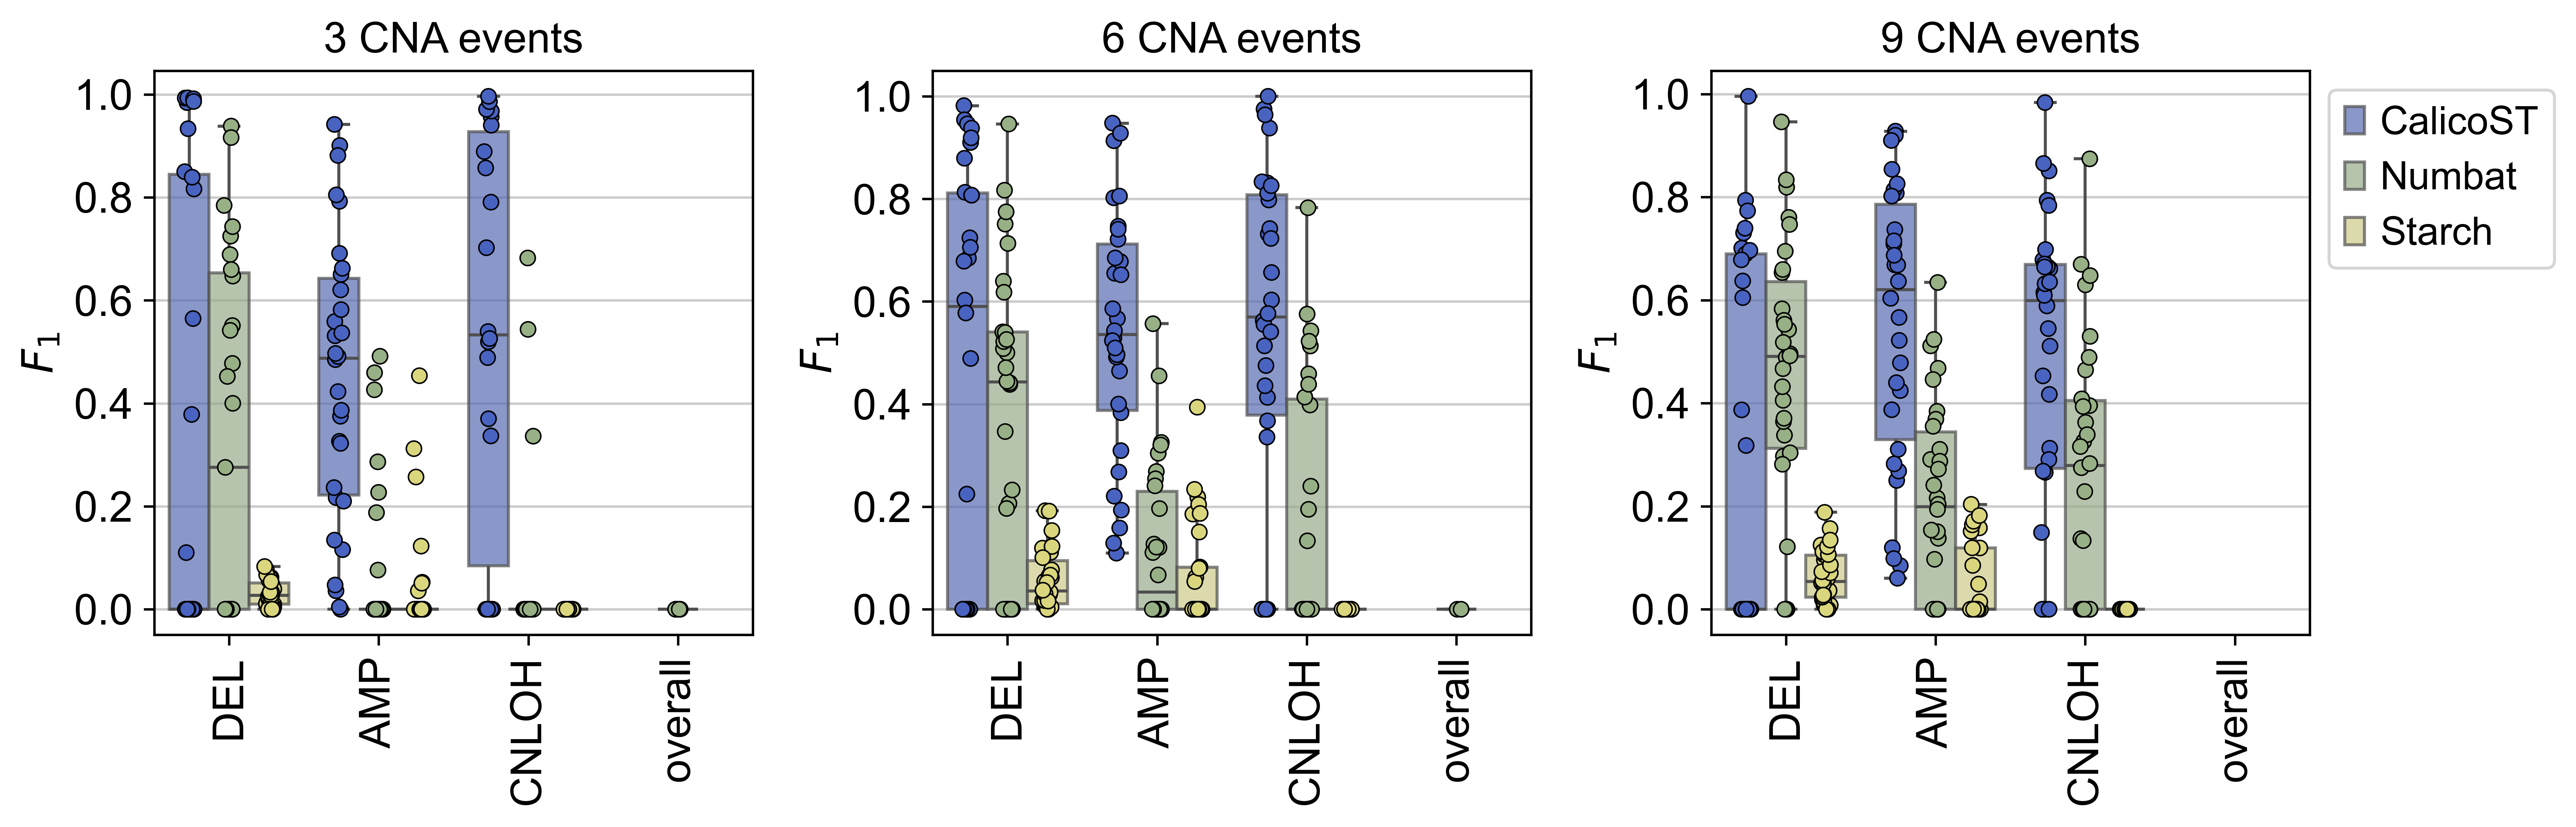

In [38]:
plot_f1s(df_event_f1)

# Done.